# Ejercicio. Red Convolucional
Objetivo: Clasificar entre imágenes de perros y gatos

In [1]:
# Importar librerías
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import random
from PIL import Image
import cv2
import glob
from tqdm.auto import tqdm # Loading bar
import os
import zipfile

# Importar paquetes para evaluación
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Importar paquetes de pytorch
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

# Importar paquetes de  torchvision packages
from torchvision import datasets
from torchvision import transforms

## Descargar conjunto de datos

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2023-10-16 22:52:48--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.145.207, 172.217.219.207, 209.85.146.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.145.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   165MB/s    in 0.4s    

2023-10-16 22:52:48 (165 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/data')
zip_ref.close()

In [4]:
data_path = Path("/content/data/")
image_path = data_path / "cats_and_dogs_filtered"

In [5]:
# Contar cantidad de imágenes en las carpetas
for dirpath, dirnames, filenames in os.walk(image_path):
    print(f"Hay {len(filenames)} imágenes en '{dirpath}'.")

Hay 1 imágenes en '/content/data/cats_and_dogs_filtered'.
Hay 0 imágenes en '/content/data/cats_and_dogs_filtered/train'.
Hay 1000 imágenes en '/content/data/cats_and_dogs_filtered/train/cats'.
Hay 1000 imágenes en '/content/data/cats_and_dogs_filtered/train/dogs'.
Hay 0 imágenes en '/content/data/cats_and_dogs_filtered/validation'.
Hay 500 imágenes en '/content/data/cats_and_dogs_filtered/validation/cats'.
Hay 500 imágenes en '/content/data/cats_and_dogs_filtered/validation/dogs'.


In [6]:
# Definir ruta de imágenes de entrenamiento y prueba
train_dir = image_path / "train"
test_dir = image_path / "validation"
train_dir, test_dir

(PosixPath('/content/data/cats_and_dogs_filtered/train'),
 PosixPath('/content/data/cats_and_dogs_filtered/validation'))

Ruta de la imagen: /content/data/cats_and_dogs_filtered/validation/cats/cat.2182.jpg
Clase: cats
Altura de la imagen: 499
Base de la altura: 375


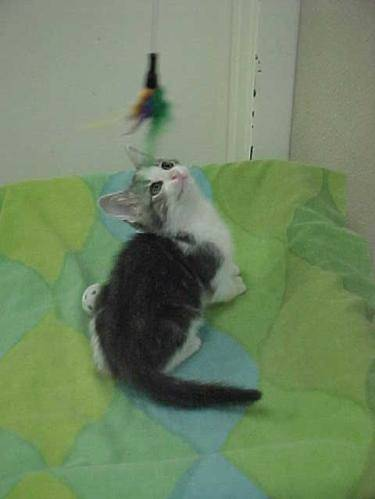

In [7]:
# Obtner todas las rutas de las imagenes en la lista(* significa cualquier combinación)
image_path_list = list(image_path.glob("*/*/*.jpg"))
# Obtener una ruta aleatoria
random_image_path = random.choice(image_path_list)
# Obtener la clase de la imagen a partir del nombre de la ruta donde está almacenada
image_class = random_image_path.parent.stem

# Abrir imagen
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Ruta de la imagen: {random_image_path}")
print(f"Clase: {image_class}")
print(f"Altura de la imagen: {img.height}")
print(f"Base de la altura: {img.width}")
img

## Preparar el conjunto de datos



La clase `ImageFolder` nos permite crear fácilmente un dataset deentrenamiento y prueba para PyTorch y posteriormente crear un dataloader iterable sin la necesidad de escribir una clase personalizada para la preparación de los datos.

**Consultar**   
[ImageFolder](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html)


In [8]:
def show_dataset(dataset, n=6):
  img = np.vstack((np.hstack((np.asarray(dataset[i][0]) for _ in range(n)))
                   for i in range(len(dataset))))
  plt.imshow(img)
  plt.axis('off')

In [9]:
# Escribir las transformaciones para preparar a las imágenes
data_transform = transforms.Compose([transforms.Resize(size=(100, 100)),
                                    transforms.ToTensor()])

In [10]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform) # transforms to perform on data (images)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 2000
    Root location: /content/data/cats_and_dogs_filtered/train
    StandardTransform
Transform: Compose(
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 1000
    Root location: /content/data/cats_and_dogs_filtered/validation
    StandardTransform
Transform: Compose(
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [11]:
# Tamaño del conjunto de datos de entrenamiento y prueba
len(train_data), len(test_data)

(2000, 1000)

In [12]:
# Nombre de las clases
class_names = train_data.classes
class_names

['cats', 'dogs']

In [13]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'cats': 0, 'dogs': 1}

In [14]:
# Obtener un elemento del conjunto de datos
img, _ = train_data[0]
print(f"Tamaño de la imagen: {img.shape}") # Channels First  (NCHW)]

Tamaño de la imagen: torch.Size([3, 100, 100])


In [15]:
# Rango de las imágenes
print(f"Valor máximo del tensor: {img.max()}")
print(f"Valor mínimo del tensor: {img.min()}")

Valor máximo del tensor: 1.0
Valor mínimo del tensor: 0.0


✍   Agregar los siguientes argumentos en la clase `DataLoader` para el conjunto de datos de entrenamiento y de pruebA:

*   `dataset` Conjunto de datos.  
*   `batch_size` Tamaño de las muestras contenidas en cada batch
*   `shuffle` Establecer a shuffle como verdadero (*True*)

In [16]:
BATCH_SIZE =64
train_dataloader = DataLoader(dataset = train_data,
                               batch_size = BATCH_SIZE,
                               shuffle = True )

In [17]:
test_dataloader = DataLoader(dataset = test_data,
                               batch_size = BATCH_SIZE,
                               shuffle =True )

In [18]:
print(f"Número de batches en el train loader: {len(train_dataloader)} batches de {BATCH_SIZE} imágenes cada uno")
print(f"Número de batches en el validation loader: {len(test_dataloader)} batches de {BATCH_SIZE} imágenes cada uno")

Número de batches en el train loader: 32 batches de 64 imágenes cada uno
Número de batches en el validation loader: 16 batches de 64 imágenes cada uno


In [19]:
# Verificar que hay dentro del DataLoader
train_batches, labels = next(iter(train_dataloader))
print(train_batches.shape)
print(f"Label shape: {labels.shape}")

torch.Size([64, 3, 100, 100])
Label shape: torch.Size([64])


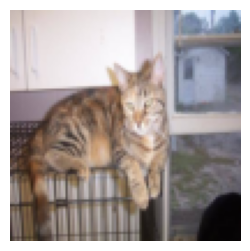

In [20]:
# Visualizar una imagen aleatoria del batch
random_idx = random.randint(0, len(train_batches)-1)
img_batch = train_batches[random_idx]
fig = plt.figure(figsize=(3,3))
plt.imshow(img_batch.squeeze().permute(1, 2, 0))
plt.axis("off")
plt.show()

In [21]:
# Configuración de CPU o GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


## Definir arquitectura del modelo

✍  Definir la arquitectura del clasificador convolucional.   

In [39]:
class CNN(nn.Module):
    def __init__(self, input_channel: int,hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channel,out_channels=hidden_units,kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units*2,kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(hidden_units*2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(in_channels=hidden_units*2,out_channels=hidden_units*2,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(hidden_units*2),
            nn.ReLU(),
            nn.MaxPool2d(2),

        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= 4608,
                      out_features=100),
            nn.Dropout(0.3),
            nn.Linear(in_features=100,
                      out_features=output_shape),
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.classifier(x)
        return x

✍  Incializar la clase CNN con los argumentos que se le solicita
- `hidden_units`: Número de filtros en las capas ocultas
- `input_channels`: Número de canales en la entrada
- `output_shape`: Salida de la red

In [40]:
# Configurar el modelo con los argumentos de entrada
cnn= CNN(input_channel=3,hidden_units=16,output_shape=1)
cnn.to(device)

CNN(
  (block_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4608, out_features=100, bias=True)
    (2): Dropout(p=0.3, inplace=False)
 

In [41]:
# Probar clasificador con entrada dummy
dummy_x = torch.rand([1,3,100,100]).to(device)
print(f"Tamaño del vector de entrada del clasificador: {dummy_x.size()}")
cnn.eval()
with torch.inference_mode():
    dummy_out = cnn(dummy_x)
print(f"Salida del clasificador: {dummy_out.shape}")
print(f"Salida del clasificador: {dummy_out}")

Tamaño del vector de entrada del clasificador: torch.Size([1, 3, 100, 100])
Salida del clasificador: torch.Size([1, 1])
Salida del clasificador: tensor([[-0.0063]], device='cuda:0')


✍ Definir optimizador
Utilizar `torch.optim.Adam` para optimizar los parámetros del discriminador y del generador.     

Agregar los siguientes argumentos en la clase:

*   `params` Parámetros a optimizar.  
*   `lr` factor de aprendizaje.

In [42]:
learning_rate =0.0001
optimizer = torch.optim.Adam(cnn.parameters(),lr = learning_rate)

✍ Definir función de costo  
Utilizar  la función de entropía cruzada binaria   
***Hint*** Revisar [BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)

In [43]:
criterion = nn.BCEWithLogitsLoss()

## Entrenamiento de la red

In [44]:
def accuracy(y_true, y_pred):
    '''Función que calcula el accuracy
    Input:
    - y_true: Tensor de etiquetas reales
    - y_pred: Tensor con las predicciones del modelo
    '''
    y_pred = y_pred.round()
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred))
    return acc

✍  Escribir el código que haga falta en la función train

In [45]:
def train(dataloader: DataLoader, model: nn.Module, loss_fn, optimizer):
    # Cambiar el modelo a entrenamiento
    model.train()
    train_loss = 0
    train_acc = 0
    # Recorrer cada batch del conjunto de entrenamiento
    for batch_idx, (data, target) in enumerate(dataloader):
        data = data.to(device)
        target = target.to(device).to(torch.float32)
        # 1. Pasar los datos por la red (feedforward)
        y_pred_logs = model(data)
        y_pred_logs = y_pred_logs.squeeze() # Quita dimensiones extra de [bacth,1] a [batch]
        # 2. Calcular la función de costo
        loss = loss_fn(y_pred_logs, target)
        train_loss += loss
        # Utilizar la función torch.sigmoid para convertir los logs a un valor entre 0 y 1
        y_pred = torch.sigmoid(y_pred_logs) #
        train_acc += accuracy(target, y_pred) # Calcular accuracy
        # 3. Zero gradient buffers
        optimizer.zero_grad()
        # 4. Backpropagate error
        loss.backward()
        # 5. Update weights
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc*100.:.4f}")
    return train_loss, train_acc

✍  Escribir el código que haga falta en la función test

In [46]:
def test(dataloader: DataLoader, model: nn.Module, loss_fn):
     # Cambiar el modelo a evaluación
    model.eval()
    test_loss = 0
    test_acc = 0
    with torch.inference_mode():
        for data, target in dataloader:
            # Cambiar datos a GPU
            data = data.to(device)
            target = target.to(device).to(torch.float32)
            # 1. Pasar los datos por la red (feedforward)
            test_pred_logs = model(data)
            test_pred_logs = test_pred_logs.squeeze()
            # 2. Calcular la función de costo
            loss = loss_fn(test_pred_logs,target)
            test_loss += loss
            # Utilizar la función torch.sigmoid para convertir los logs a un valor entre 0 y 1
            test_pred = torch.sigmoid(test_pred_logs)
            test_acc += accuracy(target,test_pred)

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

        print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc*100.:.4f}")
    return test_loss, test_acc

✍ Llenar con los argumentos correspondinetes a la función `train` y a las función `test`  

In [48]:
EPOCHS = 10

loss_train = []
acc_train = []
loss_test = []
acc_test = []

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n--------" )
    train_loss, train_acc = train(train_dataloader,cnn,criterion,optimizer)
    test_loss, test_acc = test(test_dataloader,cnn,criterion)
    loss_train.append(train_loss.item())
    loss_test.append(test_loss.item())
    acc_train.append(train_acc)
    acc_test.append(test_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
--------
Train loss: 0.68079 | Train acc: 58.2520
Test loss: 0.7231 | Test acc: 50.4883
Epoch: 1
--------
Train loss: 0.57897 | Train acc: 70.2148
Test loss: 0.5859 | Test acc: 69.3164
Epoch: 2
--------
Train loss: 0.53866 | Train acc: 73.6328
Test loss: 0.5902 | Test acc: 67.6953
Epoch: 3
--------
Train loss: 0.51233 | Train acc: 75.4883
Test loss: 0.5777 | Test acc: 69.6484
Epoch: 4
--------
Train loss: 0.47499 | Train acc: 77.5879
Test loss: 0.5483 | Test acc: 71.6016
Epoch: 5
--------
Train loss: 0.43705 | Train acc: 80.9570
Test loss: 0.5433 | Test acc: 70.8398
Epoch: 6
--------
Train loss: 0.41238 | Train acc: 82.7637
Test loss: 0.5353 | Test acc: 72.5977
Epoch: 7
--------
Train loss: 0.39427 | Train acc: 83.9844
Test loss: 0.5393 | Test acc: 72.2070
Epoch: 8
--------
Train loss: 0.36745 | Train acc: 85.1074
Test loss: 0.5330 | Test acc: 73.3008
Epoch: 9
--------
Train loss: 0.33716 | Train acc: 86.7676
Test loss: 0.5417 | Test acc: 73.7891


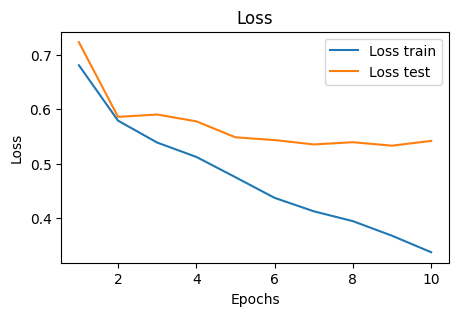

In [49]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,EPOCHS+1), loss_train)
plt.plot(np.arange(1,EPOCHS+1), loss_test)
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Loss train', 'Loss test'])
plt.show()

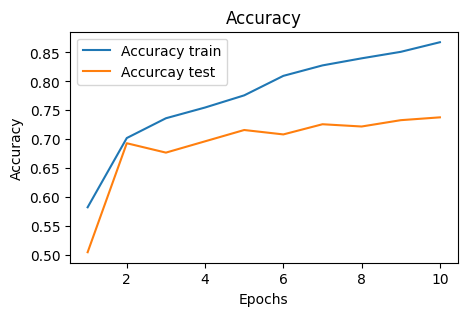

In [50]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,EPOCHS+1), acc_train)
plt.plot(np.arange(1,EPOCHS+1), acc_test)
plt.title('Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Accuracy train', 'Accurcay test'])
plt.show()

In [51]:
y_preds = []
y_true = []
cnn.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions ..."):
        X = X.to(device)
        # Pasar datos por la red
        y_pred_logs = cnn(X)
         # Utilizar la función torch.sigmoid para convertir los logs a un valor entre 0 y 1
        y_pred = torch.sigmoid(y_pred_logs)
        y_pred = torch.round(y_pred) # y_pred>0.50 -> y_pred=1 y y_pred<=0.50 -> y_pred=0
        y_preds.append(y_pred.cpu())
        y_true.append(y.cpu())

y_preds = torch.cat(y_preds)
y_true = torch.cat(y_true)

Making predictions ...:   0%|          | 0/16 [00:00<?, ?it/s]

In [52]:
y_true = y_true.numpy()
y_preds = y_preds.numpy()

✍ Utilizar la función de scikit-learn `confusion_matrix` para calcular la matriz de confusión

In [54]:
cf_matrix = confusion_matrix(y_true, y_preds)

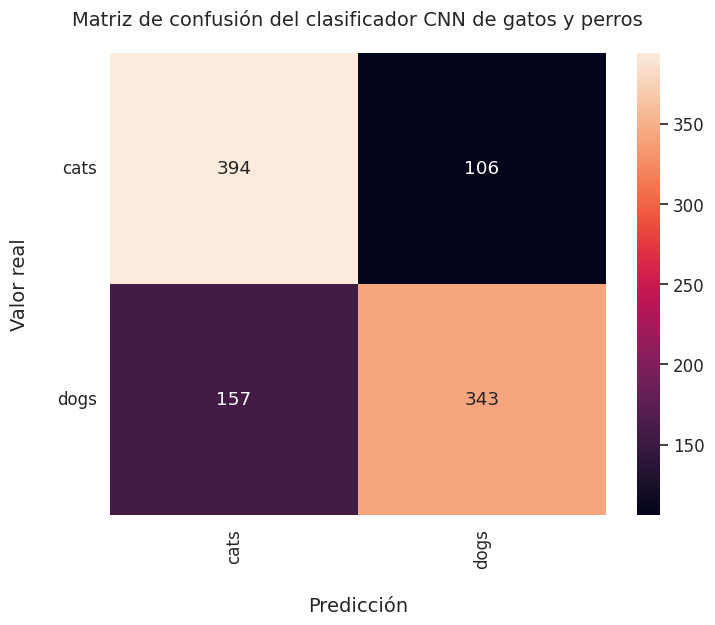

In [55]:
plt.figure(figsize=(8,6))
# Modificar el tamaño del texto
sns.set(font_scale = 1.1)

# Plot Matriz de confusión con heatmaps
# Parámetros:
# - first param - Matriz de confusión en un formato array
# - annot = True: Muestra los números en cada celda del heatmap
# - fmt = 'd': Muestra los números como enteros.
ax = sns.heatmap(cf_matrix, annot=True, fmt='d', )

# set x-axis label and ticks.
ax.set_xlabel("Predicción", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(test_data.classes, rotation=90)

# set y-axis label and ticks
ax.set_ylabel("Valor real", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(test_data.classes, rotation=0)

# set plot title
ax.set_title("Matriz de confusión del clasificador CNN de gatos y perros", fontsize=14, pad=20)
plt.show()

In [56]:
print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       0.72      0.79      0.75       500
           1       0.76      0.69      0.72       500

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.74      0.74      0.74      1000

